In [1]:
from layout import get_layout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from genetic_algo_preparation import Floorplanning, RecordBsfCosts

In [2]:
df = pd.read_csv('../refined_drug_data.csv', sep=';')
# all NaN to empty string
df = df.fillna('')

data = df.copy()
# make an array
data['drug_names'] = data[['Drug_1', 'Drug_2', 'Drug_3', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_8']].values.tolist()
# remove empty strings
data['drug_names'] = data['drug_names'].apply(lambda x: [i for i in x if i])
data = data.drop(['Drug_1', 'Drug_2', 'Drug_3', 'Drug_4', 'Drug_5', 'Drug_6', 'Drug_7', 'Drug_8'], axis=1)
data

print('Total number of combinations:', len(data))
print('Number of unique drugs:', len(data['drug_names'].explode().unique()))

# sort by freq 
sorted_drug_names = data['drug_names'].explode().value_counts().index
print('Sorted medications by frequency:', sorted_drug_names)
print('Frequency of each medication:', data['drug_names'].explode().value_counts().to_list())

Total number of combinations: 912
Number of unique drugs: 40
Sorted medications by frequency: Index(['LISINOPRIL', 'SIMVASTATIN', 'METOPROLOL', 'METFORMIN', 'LEVOTHYROXINE',
       'AMLODIPINE', 'HYDROCHLOROTHIAZIDE', 'FUROSEMIDE', 'ATORVASTATIN',
       'OMEPRAZOLE', 'ATENOLOL', 'GLIPIZIDE', 'ALBUTEROL', 'WARFARIN',
       'ASPIRIN', 'POTASSIUM CHLORIDE', 'ESOMEPRAZOLE', 'CLOPIDOGREL',
       'CARVEDILOL', 'VALSARTAN', 'LOSARTAN', 'GABAPENTIN', 'ROSUVASTATIN',
       'LOVASTATIN', 'PIOGLITAZONE', 'PRAVASTATIN', 'RANITIDINE', 'TRAMADOL',
       'IBUPROFEN', 'INSULIN GLARGINE', 'CITALOPRAM', 'ALENDRONATE',
       'ALLOPURINOL', 'MONTELUKAST', 'FEXOFENADINE', 'TAMSULOSIN', 'ZOLPIDEM',
       'SERTRALINE', 'FLUTICASONE NASAL', 'PREDNISONE'],
      dtype='object')
Frequency of each medication: [294, 270, 223, 215, 170, 159, 157, 133, 133, 127, 123, 98, 82, 81, 75, 72, 65, 65, 63, 62, 55, 54, 54, 52, 50, 48, 48, 46, 43, 42, 42, 42, 39, 34, 33, 32, 32, 32, 29, 28]


In [3]:
layout = 'doubeline_1_enter_50'

amount_of_machines = 50
machines_count = [4, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
assert sum(machines_count) == amount_of_machines, f"Sum of machines count is not equal to amount of machines: {sum(machines_count)} != {amount_of_machines}"

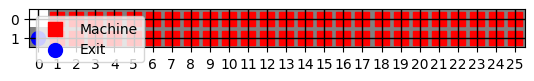

In [4]:
coord_x, coord_y, restricted_area, all_posible_positions = get_layout(layout)

exit_positions = [(0, 1)]
machine_positions = [(i, j) for i, j in all_posible_positions if not (i, j) in exit_positions]

plt.figure()
plt.imshow(restricted_area.transpose(), cmap='gray', alpha=0.5)
plt.scatter(*zip(*machine_positions), c='r', s=100, marker='s', label='Machine')
for exit_position in exit_positions:
    plt.scatter(*zip(exit_position), c='b', s=100, marker='o', label='Exit')
plt.xticks(range(coord_x))
plt.yticks(range(coord_y))

plt.legend()

plt.grid(which='major', color='k', linestyle='-', linewidth=1)
plt.show()

In [5]:
# read csv
coocurrence_matrix = np.loadtxt('../normalized_coocurrence_matrix.csv', delimiter=',')
coocurrence_matrix

array([[3.23218778e-01, 2.48874624e-01, 1.61668928e-01, ...,
        4.07896605e-02, 3.70370370e-02, 1.95792935e-02],
       [1.98862592e-01, 3.23669510e-01, 1.57729343e-01, ...,
        1.91558902e-01, 4.62962963e-02, 2.14644212e-02],
       [5.71229639e-02, 6.97467846e-02, 3.19039550e-01, ...,
        5.04857125e-02, 3.70370370e-02, 6.98124033e-03],
       ...,
       [2.26116133e-04, 1.32895820e-03, 7.92074029e-04, ...,
        3.23077987e-01, 9.25925926e-03, 4.82129857e-06],
       [8.07053209e-08, 1.26252418e-07, 2.28411514e-07, ...,
        3.63965918e-06, 2.68518519e-01, 4.82129857e-06],
       [8.19360771e-05, 1.12415153e-04, 8.26849682e-05, ...,
        3.63965918e-06, 9.25925926e-03, 3.32901024e-01]])

In [6]:
# Prepare problem
# drug_names = data['drug_names'].explode().value_counts().index


num_of_positions = len(machine_positions)
distances = np.zeros((num_of_positions, num_of_positions))
for i in range(num_of_positions):
    for j in range(num_of_positions):
        distances[i, j] = np.abs(machine_positions[i][0] - machine_positions[j][0]) + np.abs(machine_positions[i][1] - machine_positions[j][1])

# 2d array [exit_no, machine_no]
distances_to_exit = np.zeros((len(exit_positions), num_of_positions))
for exit_position in exit_positions:
    distances_to_exit[exit_position[0], :] = np.array([np.abs(machine_positions[i][0] - exit_position[0]) + np.abs(machine_positions[i][1] - exit_position[1]) for i in range(num_of_positions)])

# create array of recepts where each drug is index in drug_names
capsules = []
for i in range(len(data)):
    capsules.append([sorted_drug_names.to_list().index(drug) for drug in data['drug_names'][i]])

# make np array (for that make the same size recepts (place 0))
max_len = max([len(capsule) for capsule in capsules])
for i in range(len(capsules)):
    capsules[i] = capsules[i] + [-1] * (max_len - len(capsules[i]))
np_capsules = np.array(capsules)

In [7]:
# perm = range(40)

# Create a chromosome. Counts of machines in sorted_drug_names are given by machines_count. Create an array of machines (machines_count times each drug)
machines_chromosome = np.array([drug for drug, count in zip(sorted_drug_names, machines_count) for _ in range(count)])
machines_chromosome = np.array([sorted_drug_names.to_list().index(drug) for drug in machines_chromosome])

#### Run Genetic Algorithm

In [8]:
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.operators.crossover.ox import OrderCrossover
from pymoo.operators.mutation.inversion import InversionMutation
from pymoo.termination import get_termination
from pymoo.optimize import minimize

In [9]:
population_size = 50

perm = range(len(machines_chromosome))
init_population = np.zeros((population_size, len(machines_chromosome)))
for i in range(population_size):
    init_population[i] = np.random.permutation(perm)

problem = Floorplanning(perm, machines_chromosome, np_capsules, distances, distances_to_exit, layout, coocurrence_matrix)

In [10]:
algorithm = GA(
    pop_size=population_size, 
    eliminate_duplicates=True, 
    sampling=init_population, 
    crossover=OrderCrossover(), 
    mutation=InversionMutation(), 
    # termination=get_termination("n_gen", 50)
)
n_eval = 10000 # 25000 / 50 = 500 generations
print(f'Number of evaluations: {n_eval}, generations: {n_eval/population_size}')
termination = get_termination("n_eval", n_eval) 
res = minimize(
    problem,
    algorithm,
    termination,
    save_history=True,
    callback=RecordBsfCosts(),
    # seed=1,
)
# unique datetime for saving
import datetime
now = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
print("date: ", now)

Number of evaluations: 10000, generations: 200.0
Generation: 100 | Best cost: 5068.581285777665
Generation: 200 | Best cost: 4944.368697172806


In [11]:
print('Cost (through all recepts): ', res.F)
print('Permutation: ', res.X)
print('Number of iterations (for population, not candidate): ', res.history.__len__())

Cost (through all recepts):  [4944.36869717]
Permutation:  [17. 16. 19. 11. 10.  2.  6.  7. 15. 12. 24. 20. 26. 18. 27. 22. 37.  5.
 32.  4. 23. 35. 41. 33. 34. 46. 40. 38. 45. 47. 29. 25. 28. 43. 31. 39.
 48. 49. 42. 30. 36.  0.  1.  3. 13. 14. 44. 21.  8.  9.]
Number of iterations (for population, not candidate):  200


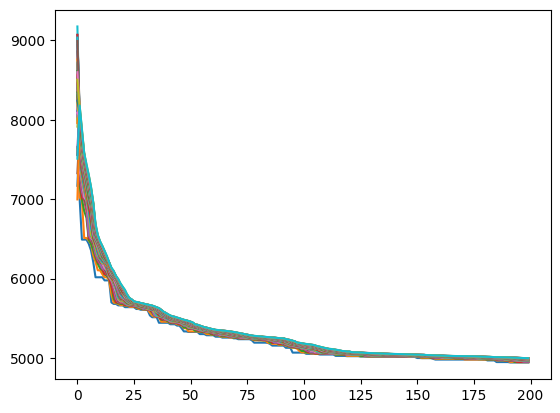

In [12]:
# plot best so far costs line ([i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']])
plt.figure()
# plt.plot([i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']]) min 
plt.plot([i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']])
plt.show()

In [21]:
np.savez(f'../results/{layout}_{n_eval}_popsize_{population_size}_order_inversion_{now}.npz', 
    layout=layout, 
    population_size=population_size, 
    inlet_positions=exit_positions,

    machine_positions=machine_positions,
    machines_drug_names=np.array([sorted_drug_names[drug] for drug in machines_chromosome]),

    gen_best_cost=res.F, 
    gen_best_perm=res.X, # permutation of idxs of machines_drug_names
    n_eval=n_eval,
    bsf_costs=[i.reshape(-1) for i in res.algorithm.callback.data['bsf_costs']],
    gen_description= f'Number of evaluations: {n_eval}, generations: {n_eval/population_size}, operator: OrderCrossover, InversionMutation',
)
now

'20240729133337'